In [4]:
import optuna
import pandas as pd
import sys
import matplotlib.pyplot as plt
sys.path.append('/opt/ml/code/src/')

from utils import seed_everything, roc_auc_score
from model import lgbm
from features import feature_engineering

SEED = 42  # 랜덤 시드
seed_everything(SEED)  # 시드 고정

In [5]:
# 데이터 파일 읽기
data = pd.read_csv("/opt/ml/code/input/train.csv", parse_dates=["order_date"])

# 피처 엔지니어링 실행
train, test, y, features = feature_engineering(data, '2011-12')

categorical feature: []
train_set.shape (5722, 142) , test_set.shape (5914, 142)


In [43]:
def objective(trial):
    lgb_params = {
        'objective': 'binary', # 이진 분류
        'boosting_type': 'gbdt',
        'learning_rate': 0.025,
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),

        # # num_leaves 값을 2-256까지 정수값 중에 사용
        # 'num_leaves': trial.suggest_int('num_leaves', 2, 256),

        # # max_bin 값을 128-256까지 정수값 중에 사용 
        # 'max_bin': trial.suggest_int('max_bin', 128, 256), 

        # # min_data_in_leaf 값을 10-40까지 정수값 중에 사용
        # 'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 40),

        # # 피처 샘플링 비율을 0.4-1.0까지 중에 uniform 분포로 사용
        # 'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),

        # # 데이터 샘플링 비율을 0.4-1.0까지 중에 uniform 분포로 사용
        # 'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),

        # # 데이터 샘플링 횟수를 1-7까지 정수값 중에 사용
        # 'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),

        # # 트리 개수
        # 'n_estimators': trial.suggest_int('n_estimators', 100, 100000), 
        # 'early_stopping_rounds': 100,

        # 'seed': SEED,
        # 'verbose': -1,   
    }
    
    # oof prediction 함수 호출해서 out of fold validation 예측값을 얻어옴
    y_oof, test_preds = lgbm(train, y, test, features, lgb_params, WANDB_USE=False)
    
    # Validation 스코어 계산
    val_auc = roc_auc_score(y, y_oof)
    
    return val_auc

In [41]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials = 100)

val.shape: (573, 139)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[77]	training's auc: 0.86739	valid_1's auc: 0.804733
Fold 1 | AUC: 0.8047329063784106
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 139), x_val.shape: (573, 139)
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.914247	valid_1's auc: 0.804798
Early stopping, best iteration is:
[147]	training's auc: 0.897504	valid_1's auc: 0.814349
Fold 2 | AUC: 0.8143486469477658
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 139), x_val.shape: (572, 139)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[77]	training's auc: 0.865741	valid_1's auc: 0.843164
Fold 3 | AUC: 0.8431643395803778
--------------------------------------------------------------------------------
fold: 4, x_t

KeyboardInterrupt: 

In [1]:
study.best_value

NameError: name 'study' is not defined

In [39]:
study.best_params

{'learning_rate': 0.02415360413826518}

In [22]:
study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_bagging_fraction,params_bagging_freq,params_feature_fraction,params_learning_rate,params_max_bin,params_min_data_in_leaf,params_n_estimators,params_num_leaves,state
0,0,0.803850,2021-04-21 14:04:08.002497,2021-04-21 14:04:17.731293,0 days 00:00:09.728796,0.519197,5,0.611919,0.086898,166,10,91574,74,COMPLETE
1,1,0.810436,2021-04-21 14:04:17.733096,2021-04-21 14:04:38.142348,0 days 00:00:20.409252,0.898202,6,0.591582,0.075208,228,19,92383,215,COMPLETE
2,2,0.810474,2021-04-21 14:04:38.143740,2021-04-21 14:04:50.069706,0 days 00:00:11.925966,0.697748,2,0.675462,0.072069,147,20,38074,182,COMPLETE
3,3,0.813727,2021-04-21 14:04:50.070951,2021-04-21 14:05:03.409732,0 days 00:00:13.338781,0.712940,7,0.864001,0.055626,216,27,3278,165,COMPLETE
4,4,0.819475,2021-04-21 14:05:03.411025,2021-04-21 14:05:07.897505,0 days 00:00:04.486480,0.553269,4,0.802500,0.099322,199,19,7843,12,COMPLETE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,0.825698,2021-04-21 14:32:19.082276,2021-04-21 14:32:25.936525,0 days 00:00:06.854249,0.718584,4,0.570866,0.018911,213,30,92599,7,COMPLETE
96,96,0.824228,2021-04-21 14:32:25.938184,2021-04-21 14:32:35.314942,0 days 00:00:09.376758,0.716331,4,0.529520,0.017801,213,29,97346,24,COMPLETE
97,97,0.824685,2021-04-21 14:32:35.317307,2021-04-21 14:32:52.038765,0 days 00:00:16.721458,0.667055,4,0.602717,0.023562,210,26,93617,6,COMPLETE
98,98,0.823367,2021-04-21 14:32:52.040279,2021-04-21 14:33:10.084726,0 days 00:00:18.044447,0.738807,4,0.620646,0.012318,212,23,91731,18,COMPLETE


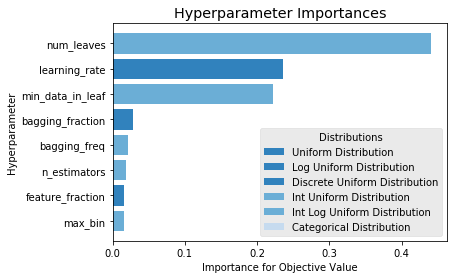

In [23]:
optuna.visualization.matplotlib.plot_param_importances(study)
plt.show()

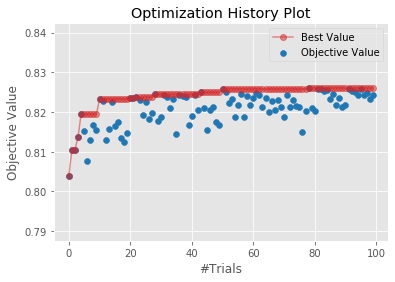

In [24]:
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.show()

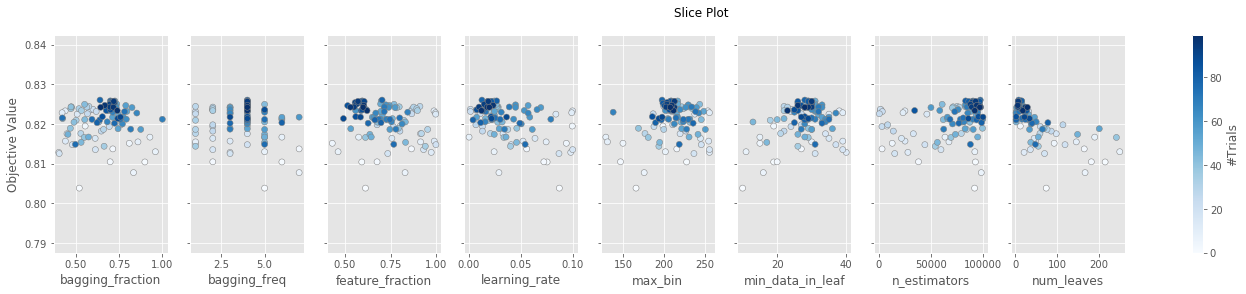

In [25]:
optuna.visualization.matplotlib.plot_slice(study)
plt.show()

[W 2021-04-21 14:42:54,507] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


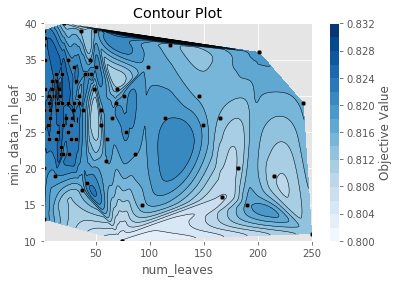

In [26]:
optuna.visualization.matplotlib.plot_contour(study, params=['num_leaves','min_data_in_leaf'])
plt.show()

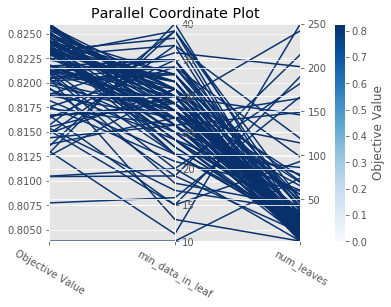

In [27]:
optuna.visualization.matplotlib.plot_parallel_coordinate(study, params=['num_leaves','min_data_in_leaf'])
plt.show()